# Импорты

In [199]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn import tree
%matplotlib inline
sns.set(style="whitegrid")

from sklearn.preprocessing import MinMaxScaler

# Загрузка датасета

In [200]:
data = pd.read_csv('/content/ebw_data.csv')

In [201]:
data.head()

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


# Разведочный анализ данных
На данном этапе ознакомимся с данными для понимания распределения данных и выявления возможных зависимостей между переменными.

Данные:
* IW (снижение величины сварочного тока);
* IF (ток фокусировки электронного пучка);
* VW (скорость сварки);
* FP (расстояние от поверхности образцов до электронно-оптической системы);
* Глубина шва (Depth);
* Ширина шва (Width).

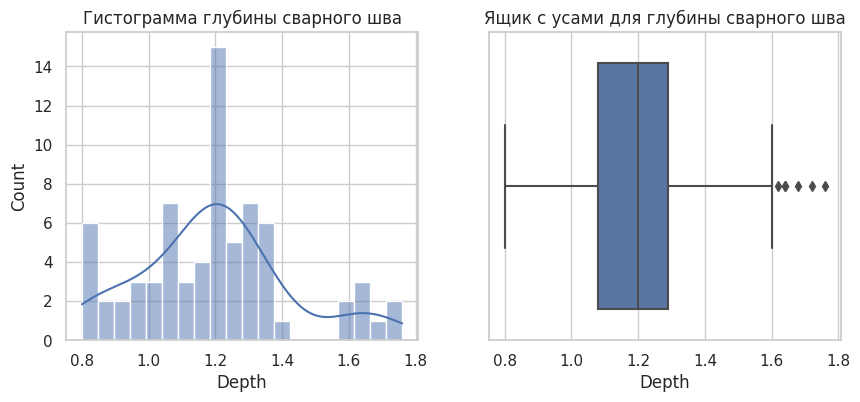

In [202]:
# Гистограммы и ящики с усами
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(data.Depth, bins=20, kde=True)
plt.title('Гистограмма глубины сварного шва')
plt.subplot(1, 2, 2)
sns.boxplot(x=data.Depth)
plt.title('Ящик с усами для глубины сварного шва')
plt.show()

Из графика гистограммы глубины сварного шва можно сделать следующие наблюдения:

Распределение глубины сварного шва имеет несколько мод. Это может указывать на наличие различных процессов сварки или влияние разных параметров на глубину шва.

Есть несколько выбросов значений, выходящих за пределы основного диапазона. Эти выбросы могут быть результатом особенных условий сварки или ошибок измерения.

На основе графика ящика с усами можно сделать следующие наблюдения:

Медиана глубины сварного шва находится около 1.2 мм.

Верхний и нижний квартили указывают на то, что большинство значений находятся между примерно 0.8 и 1.6 мм.

Есть несколько выбросов значений с глубиной сварного шва ниже 0.8 мм и выше 1.6 мм.

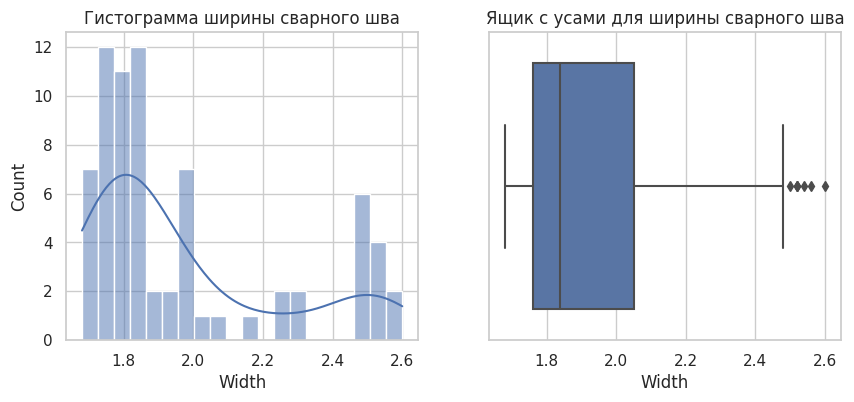

In [203]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(data.Width, bins=20, kde=True)
plt.title('Гистограмма ширины сварного шва')
plt.subplot(1, 2, 2)
sns.boxplot(x=data.Width)
plt.title('Ящик с усами для ширины сварного шва')
plt.show()

Гистограмма ширины сварного шва:

Распределение ширины сварного шва имеет несколько мод, подобно распределению глубины сварного шва. Это может свидетельствовать о различных процессах сварки или влиянии разных параметров на ширину сварного соединения.

Есть несколько выбросов значений, выходящих за пределы основного диапазона. Эти выбросы могут быть результатом особенных условий сварки или ошибок измерения.

Ящик с усами для ширины сварного шва:

Медиана ширины сварного шва находится около 1.9 мм.

Верхний и нижний квартили указывают на то, что большинство значений находятся между примерно 1.7 и 2.5 мм.

Есть несколько выбросов значений с шириной сварного шва ниже 1.7 мм и выше 2.5 мм.

Выводы:
Ширина сварного шва в также имеет разнообразное распределение с несколькими модами и наличием выбросов, аналогично глубине сварного соединения.
Но так как у нас очень мало значений, мы не будем удалять выбросы (тем более мы не можем быть уверены в некорректности данных значений).

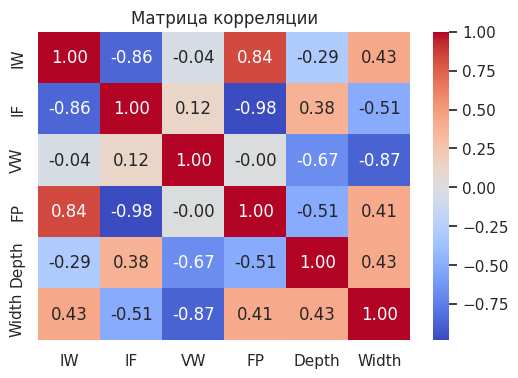

In [204]:
# Матрица корреляции
correlation_matrix = data.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляции')
plt.show()

* IW (снижение величины сварочного тока):

Отрицательная корреляция с IF (-0.86) указывает на сильную обратную зависимость между снижением величины сварочного тока и током фокусировки электронного пучка.
Положительная корреляция с FP (0.84) говорит о том, что увеличение снижения величины сварочного тока связано с увеличением расстояния от поверхности образцов до электронно-оптической системы.
Этот параметр не имеет сильной корреляции с глубиной или шириной сварного соединения.
* IF (ток фокусировки электронного пучка):

Отрицательная корреляция с FP (-0.98) означает, что уменьшение тока фокусировки связано с увеличением расстояния от поверхности образцов до электронно-оптической системы.
Этот параметр также не имеет сильной корреляции с глубиной или шириной сварного соединения.
* VW (скорость сварки):

Отрицательная корреляция с FP (-0.001) означает, что скорость сварки практически не коррелирует с расстоянием от поверхности образцов до электронно-оптической системы.
Отрицательная корреляция с Depth (-0.67) и Width (-0.87) говорит о том, что увеличение скорости сварки связано с уменьшением глубины и ширины сварного соединения.


Есть признаки, которые сильно коррелируют между собой, например, FP с IW (0.84) или имеют высокую обратную корреляцию, как IF c IW (-0.86).
Важно помнить, что корреляция сама по себе не означает причинно-следственной связи между переменными, и мы не всегда должны удалять признаки только из-за сильной корреляции. Однако, при построении модели, можно попробовать удалить один из столбцов, которые сильно коррелируют между собой (например, как IF и FP), так как это может указывать на мультиколлинеарность, что может быть проблемой для некоторых моделей регрессии.


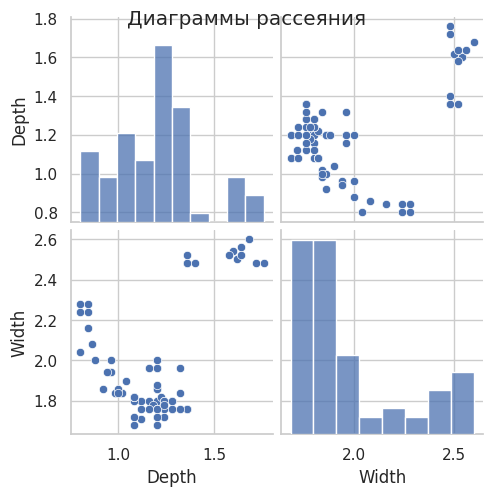

In [205]:
# Диаграммы рассеяния
sns.pairplot(data, vars=['Depth', 'Width'], kind='scatter')
plt.suptitle('Диаграммы рассеяния')
plt.show()

Диаграмма рассеяния позволяет нам визуально оценить отношение между глубиной и шириной сварного соединения. Обратная зависимость между этими двумя параметрами видна, но она не является строго линейной, и существует разброс значений.

##Предобработка данных

Обработка отсутствующих значений:

In [206]:
data.isnull().sum()

IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64

В данном датасете нет пустых значений.

Также пропускаем этап: Кодирование категориальных переменных, т.к. в датасете только количественные переменные(dtype: int64).

Масштабирование признаков:

Нормализацию применяю только к независимым признакам ('IW', 'IF', 'VW', 'FP'), т.к. нормализация целевых переменных может привести к затруднению интерпретации результатов.

In [207]:
X = data.drop(["Width", "Depth"], axis=1)
Y = data[["Width", "Depth"]].copy()
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    train_size=0.8,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    shuffle=True)

In [208]:
X_train.head()

,IW,IF,VW,FP
55,43,150,9.0,50
70,45,146,9.0,60
62,43,146,9.0,60
43,47,140,10.0,80
4,45,140,4.5,80


In [209]:
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)
# возвращаем название столбцов
X_train_norm = pd.DataFrame(data=X_train_norm, columns=[ 'IW', 'IF', 'VW', 'FP'])
X_test_norm = pd.DataFrame(data=X_test_norm, columns=[ 'IW', 'IF', 'VW', 'FP'])

Выбор признаков

Есть несколько признаков, которые сильно коррелируют друг с другом, рассмотрим след. варианты:

1. Оставить все признаки и посмотреть, как они влияют на модель.
2. Удалить один из сильно коррелированных признаков.

In [210]:
# Оставить все признаки и посмотреть, как они влияют на модель.
X_train_v1 = X_train_norm
X_test_v1 = X_test_norm
# Корреляция FP c IW (0.84) и FP с IF (-0.98)
X_train_v2 = X_train_norm.drop('FP', axis=1)
X_test_v2 = X_test_norm.drop('FP', axis=1)

Разделение данных

так как мы имеем небольшую выборку (72, 6), то оптимальным решением для разделением данных будет кросс-валидацию.

# Создание модели
## Линейная регрессия
### датасет 1

In [211]:
%%time
# Создание модели
model_1 = MultiOutputRegressor(LinearRegression())

# Обучение модели на всем обучающем наборе данных
model_1.fit(X_train_v1, Y_train)

# Оценка модели на тестовых данных
Y_pred = model_1.predict(X_test_v1)
mse = mean_squared_error(Y_test, Y_pred, multioutput='raw_values')

print("Среднеквадратичная ошибка на тестовых данных:", mse)

Среднеквадратичная ошибка на тестовых данных: [0.00659689 0.02090893]
CPU times: user 13.4 ms, sys: 0 ns, total: 13.4 ms
Wall time: 15.7 ms


### датасет 2

In [212]:
%%time
model_2 = MultiOutputRegressor(LinearRegression())
# Обучение модели на всем обучающем наборе данных
model_2.fit(X_train_v2, Y_train)

# Оценка модели на тестовых данных
Y_pred = model_2.predict(X_test_v2)
mse = mean_squared_error(Y_test, Y_pred, multioutput='raw_values')

print("Среднеквадратичная ошибка на тестовых данных:", mse)

Среднеквадратичная ошибка на тестовых данных: [0.00655485 0.01385547]
CPU times: user 13 ms, sys: 0 ns, total: 13 ms
Wall time: 13 ms


1. Полный датасет (включая столбец FP) имеет следующие значения MSE для двух целевых переменных: [0.00659689, 0.02090893].

2. Когда столбец FP был удален из датасета, MSE уменьшилась для обеих целевых переменных: [0.00655485, 0.01385547].

Это может означать, что удаление столбца FP из датасета улучшило производительность модели, поскольку MSE уменьшилась для обеих целевых переменных. Корреляция может указывать на мультиколлинеарность, что может привести к нестабильным или менее точным оценкам модели. Но также это может означать:
1. Переобучение: у нас мало наблюдений, включение или исключение конкретных признаков может влиять на производительность модели из-за ограниченного размера обучающей выборки. Модель может переобучаться на конкретных признаках, что может привести к изменению ее поведения.
2. Случайность: Возможно, что различия в ошибках при использовании исходных данных и данных без столбца FP могут быть случайными.

Чтобы исклучить возможность переобучения и случайности - попробуем след. модели:


## Случайный лес
###(так же используем GridSearchCV - для выбора лучших парметров)
### датасет 1

In [213]:
%%time
# Создание модели
model_1 = MultiOutputRegressor(RandomForestRegressor())
# Выбор праметров
parametrs = {
    'estimator__n_estimators': list(range(30, 50, 2)),
    'estimator__max_depth': list(range(5, 10)),
    'estimator__min_samples_leaf': list(range(1,5,2)),
    'estimator__min_samples_split': list(range(2, 5, 2))
}
grid_search_cv1 = GridSearchCV(model_1, parametrs, cv=5, n_jobs=-1)
# Обучение модели на всем обучающем наборе данных
grid_search_cv1.fit(X_train_v1, Y_train)
# Лучшие параметры и модель
best_params_v1 = grid_search_cv1.best_params_
best_model_v1 = grid_search_cv1.best_estimator_
# Оценка производительности на тестовых данных
Y_pred_v1 = best_model_v1.predict(X_test_v1)
mse_v1 = mean_squared_error(Y_test, Y_pred_v1, multioutput='raw_values')

print("Лучшие параметры и MSE для пайплайна с X_train_v1:")
print(best_params_v1)
print("Среднеквадратичная ошибка на тестовых данных:", mse_v1)


Лучшие параметры и MSE для пайплайна с X_train_v1:
{'estimator__max_depth': 9, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 48}
Среднеквадратичная ошибка на тестовых данных: [0.00515384 0.01065399]
CPU times: user 2.59 s, sys: 305 ms, total: 2.9 s
Wall time: 1min 12s


### датасет 2

In [214]:
%%time
model_2 = MultiOutputRegressor(RandomForestRegressor())
parametrs = {
    'estimator__n_estimators': list(range(30, 50, 2)),
    'estimator__max_depth': list(range(5, 10)),
    'estimator__min_samples_leaf': list(range(1,5,2)),
    'estimator__min_samples_split': list(range(2, 5, 2))
}
grid_search_cv2 = GridSearchCV(model_2, parametrs, cv=5, n_jobs=-1)
# Обучение модели без столбца FP
grid_search_cv2.fit(X_train_v2, Y_train)
best_params_v2 = grid_search_cv2.best_params_
best_model_v2 = grid_search_cv2.best_estimator_
Y_pred_v2 = best_model_v2.predict(X_test_v2)
mse_v2 = mean_squared_error(Y_test, Y_pred_v2, multioutput='raw_values')

print(f"Лучшие параметры и MSE для пайплайна с X_train_v2: {best_params_v2}")
print("Среднеквадратичная ошибка на тестовых данных:", mse_v2)

Лучшие параметры и MSE для пайплайна с X_train_v2: {'estimator__max_depth': 5, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 38}
Среднеквадратичная ошибка на тестовых данных: [0.00560029 0.00986521]
CPU times: user 1.89 s, sys: 220 ms, total: 2.11 s
Wall time: 1min 12s


1. Среднеквадратичная ошибка на тестовых данных (без удаления столбцов): [0.00515384 0.01065399].

2. Среднеквадратичная ошибка на тестовых данных(без столбца FP): [0.00560029 0.00986521].


Сравнение с линейной регрессией:
1. У обеих моделей случайного леса (с FP и без FP) среднеквадратичная ошибка ниже, чем у линейной регрессии. Это может указывать на то, что случайный лес лучше подходит для данной задачи регрессии.

2. Cтолбец FP не имеет значительного влияния на производительность модели случайного леса в данном случае.
Вероятно, различия в среднеквадратичной ошибке можно объяснить случайными факторами или ограниченным размером обучающей выборки.

##Градиентный бустинг
### датасет 1

In [215]:
%%time
# Создание модели
model_gb_1 = MultiOutputRegressor(GradientBoostingRegressor())

# Определение параметров для поиска
parametrs_gb = {
    'estimator__n_estimators': list(range(1, 100, 10)),
    'estimator__max_depth': list(range(1, 10)),
    'estimator__learning_rate': [0.01],
}
grid_search_cv_gb = GridSearchCV(model_gb_1, parametrs_gb, cv=5, n_jobs=-1)
# Обучение модели на всем обучающем наборе данных
grid_search_cv_gb.fit(X_train_v1, Y_train)
# Лучшие параметры и модель
best_params_gb = grid_search_cv_gb.best_params_
best_model_gb = grid_search_cv_gb.best_estimator_
# Оценка производительности на тестовых данных
Y_pred_gb = best_model_gb.predict(X_test_v1)
mse_gb = mean_squared_error(Y_test, Y_pred_gb, multioutput='raw_values')

print(f"Лучшие параметры и MSE для градиентного бустинга с X_train_v2: {best_params_gb}")
print("Среднеквадратичная ошибка на тестовых данных:", mse_gb)

Лучшие параметры и MSE для градиентного бустинга с X_train_v2: {'estimator__learning_rate': 0.01, 'estimator__max_depth': 7, 'estimator__n_estimators': 91}
Среднеквадратичная ошибка на тестовых данных: [0.01673206 0.00708907]
CPU times: user 497 ms, sys: 61.5 ms, total: 558 ms
Wall time: 14.5 s


### датасет 2

In [216]:
%%time
# Создание модели
model_gb_2 = MultiOutputRegressor(GradientBoostingRegressor())

# Определение параметров для поиска
parametrs_gb = {
    'estimator__n_estimators': list(range(1, 100, 10)),
    'estimator__max_depth': list(range(1, 10)),
    'estimator__learning_rate': [0.01],
}
grid_search_cv_gb = GridSearchCV(model_gb_2, parametrs_gb, cv=5, n_jobs=-1)
# Обучение модели на всем обучающем наборе данных
grid_search_cv_gb.fit(X_train_v2, Y_train)
# Лучшие параметры и модель
best_params_gb = grid_search_cv_gb.best_params_
best_model_gb = grid_search_cv_gb.best_estimator_
# Оценка производительности на тестовых данных
Y_pred_gb = best_model_gb.predict(X_test_v2)
mse_gb = mean_squared_error(Y_test, Y_pred_gb, multioutput='raw_values')

print(f"Лучшие параметры и MSE для градиентного бустинга с X_train_v2: {best_params_gb}")
print("Среднеквадратичная ошибка на тестовых данных:", mse_gb)

Лучшие параметры и MSE для градиентного бустинга с X_train_v2: {'estimator__learning_rate': 0.01, 'estimator__max_depth': 7, 'estimator__n_estimators': 91}
Среднеквадратичная ошибка на тестовых данных: [0.01673206 0.00708907]
CPU times: user 589 ms, sys: 52.5 ms, total: 642 ms
Wall time: 15.2 s


Полный датасет (включая столбец FP) для модели градиентного бустинга имеет следующие значения MSE для двух целевых переменных: [0.01673206 0.00708907].

Когда столбец FP был удален из датасета, MSE остались практически неизменными и составили [0.01673206 0.00708907]. Это может указывать на то, что в данном конкретном случае столбец FP не оказывает существенного влияния на производительность модели градиентного бустинга. Возможно, модель градиентного бустинга более устойчива к корреляции и мультиколлинеарности, чем другие модели, такие как линейная регрессия и случайный лес.

Также стоит отметить, что размер выборки (72 значения) может оказать влияние на разницу в производительности модели. Изменения могут быть менее выраженными в случае ограниченного объема данных.


Вывод:

1. Удаление столбца FP из датасета оказало существенное влияние на производительность модели линейной регрессии, улучшив ее результаты. Однако для модели случайного леса и градиентного бустинга столбец FP не оказал значительного влияния.

2. Возможно, модель градиентного бустинга оказалась более устойчивой к корреляции и мультиколлинеарности по сравнению с другими моделями.

3. С учетом анализа и сравнения производительности моделей, модель случайного леса показала наилучшие результаты с минимальными значениями MSE для обоих целевых переменных (Width и Depth). Модель градиентного бустинга также показала хорошие результаты для Depth, но значение MSE для Width сильно хуже, чем у случайного леса.

На основании анализа, можно сделать вывод, что модель случайного леса является предпочтительным выбором для решения данной задачи регрессии, поскольку она продемонстрировала наилучшую производительность с наименьшими ошибками.